In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
spack_sorted_commits = pd.read_csv("/content/drive/MyDrive/SortedCommits/spack_sorted_commits.csv").drop(columns=['Unnamed: 0'])

In [ ]:
spack_sorted_commits.head()

,year,month,day,doy,dow,full_date,files,files_dict,message,person,locc,locc+,locc-,sha
0,2013,2,13,44,Wednesday,2013-02-13 17:50:44-08:00,"['a/.gitignore b/.gitignore', 'a/bin/spack b/b...","{'a/.gitignore b/.gitignore': [4, 4, 0], 'a/bi...",Initial version of spack with one package:...,b'Todd Gamblin <tgamblin@llnl.gov>',1094,1094,0,b'cc76c0f5f9f8021cfb7423a226bd431c00d791ce'
1,2013,2,18,49,Monday,2013-02-18 23:52:50-08:00,['a/bin/spack b/bin/spack'],"{'a/bin/spack b/bin/spack': [2, 1, 1]}",Require python2.7\n,b'Todd Gamblin <tgamblin@llnl.gov>',2,1,1,b'5d81cfdac67feb2abd4b7b727fe512c5381b7b76'
2,2013,2,18,49,Monday,2013-02-18 23:46:04-08:00,['a/bin/spack b/bin/spack'],"{'a/bin/spack b/bin/spack': [2, 1, 1]}","Dependencies now work. Added libelf, libd...",b'Todd Gamblin <tgamblin@llnl.gov>',2,1,1,b'38becacacee43b40d02e33c97f0dc3bda83f42e6'
3,2013,2,19,50,Tuesday,2013-02-19 19:26:54-08:00,['a/lib/spack/env/cc b/lib/spack/env/cc'],"{'a/lib/spack/env/cc b/lib/spack/env/cc': [3, ...",Fixed passing of dependence prefixes to cc...,b'Todd Gamblin <tgamblin@llnl.gov>',3,2,1,b'48b03519456084d0c4ddd8b35567b3b26eb679b7'
4,2013,2,19,50,Tuesday,2013-02-19 17:08:38-08:00,['a/lib/spack/env/cc b/lib/spack/env/cc'],"{'a/lib/spack/env/cc b/lib/spack/env/cc': [6, ...","Fixes, remove parallel build for libdwarf ...",b'Todd Gamblin <tgamblin@llnl.gov>',6,3,3,b'd534c539d44fa036510f4afd455d7b0521c092e7'


In [ ]:
spack_sorted_commits.tail()

,year,month,day,doy,dow,full_date,files,files_dict,message,person,locc,locc+,locc-,sha
15718,2020,9,9,253,Wednesday,2020-09-09 04:28:27+02:00,['a/var/spack/repos/builtin/packages/openscene...,{'a/var/spack/repos/builtin/packages/openscene...,openscenegraph: remove dependency on Qt fo...,b'Martin Aum\xc3\xbcller <aumuell@reserv.at>',3,2,1,b'ab51edecb5becd17d172e33581a5f00f6553466c'
15719,2020,9,9,253,Wednesday,2020-09-09 04:05:18+02:00,['a/var/spack/repos/builtin/packages/texlive/p...,{'a/var/spack/repos/builtin/packages/texlive/p...,Update package.py (#18552)\n \n with...,b'Jaroslav Hron <hron@karlin.mff.cuni.cz>',3,3,0,b'e2e90e4d6b811e3f4eec5589cd71182ed6bf5f0c'
15720,2020,9,9,253,Wednesday,2020-09-09 03:56:08+02:00,['a/var/spack/repos/builtin/packages/go/packag...,{'a/var/spack/repos/builtin/packages/go/packag...,go: Add 1.15.1 and 1.14.8 (#18575)\n,b'Michael Kuhn <michael.kuhn@ovgu.de>',2,2,0,b'017331684e4c116274c6836915b5d5c21681d177'
15721,2020,9,9,253,Wednesday,2020-09-09 03:55:40+02:00,['a/var/spack/repos/builtin/packages/node-js/p...,{'a/var/spack/repos/builtin/packages/node-js/p...,node-js: Add 14.10.0 and 12.18.3 (#18576)\n,b'Michael Kuhn <michael.kuhn@ovgu.de>',1,1,0,b'e43855bc8fa0e808f24b7919ee85834bc2c2ab3b'
15722,2020,9,9,253,Wednesday,2020-09-09 03:55:12+02:00,['a/var/spack/repos/builtin/packages/npm/packa...,{'a/var/spack/repos/builtin/packages/npm/packa...,npm: Add 6.14.8 (#18577)\n,b'Michael Kuhn <michael.kuhn@ovgu.de>',2,1,1,b'9c4d79f8cdef3dbc551dd29af5081b62c0d73e8e'


In [ ]:
import sys 
def sorted_people_commits(year=None, sorted=True):
  """return list of commits per user as panda dataframes (slices of the original) sorted in descending order by rows. Filter out users with no commits

  param  : year as time window from which to search 
  
  """
  people_commits = []
  seen = {}
  for i in range(len(spack_sorted_commits['person'].index)):
    try:
      throw_away = seen[spack_sorted_commits['person'][i]]
      if throw_away == 1:
        continue 
    except KeyError:
      seen[spack_sorted_commits['person'][i]] = 1
      comm_p_year = None  
      if year is None:
        comm_p_year = True 
      else:
        comm_p_year = (spack_sorted_commits['year'] == year)
      commits_by_p = spack_sorted_commits[comm_p_year & (spack_sorted_commits['person'] == spack_sorted_commits['person'][i])]
      people_commits.append(commits_by_p)
  people_commits = list(filter(lambda x: len(x['full_date']) > 0, people_commits))
  if sorted:
    people_commits.sort(key=lambda x: len(x['full_date']), reverse=True)
  return people_commits

In [ ]:
years = list(set(list(spack_sorted_commits['year'])))

In [ ]:
people_n1 = len(list(set(list(spack_sorted_commits['person']))))

In [ ]:
len(sorted_people_commits())

844

In [ ]:
import itertools
people = [list(itertools.chain.from_iterable([list(set(list(e['person']))) for e in sorted_people_commits(y)])) for y in years]

In [ ]:
people_s = set() 
for l in people: 
  people_s = people_s.union(set(l))
people_n2 = len(list(people_s))

In [ ]:
people_n1 == people_n2 

True

In [ ]:
def all_files(year=None):
  """return list of (file, count) tuples sorted by count

  param  : year as time window 
  """
  ppl_commits = sorted_people_commits(year)
  seen = {}
  for i in range(len(ppl_commits)):
    df = ppl_commits[i]
    file_lists = [eval(l) for l in list(df['files'])]
    for l_file in file_lists:
      for file in l_file:
        try:
          seen[file] += 1
        except KeyError:
          seen[file] = 1 
  seen_sorted = sorted(seen.items(), key=lambda x : x[1], reverse=True)
  return seen_sorted

In [ ]:
def make_indices(year=None, sorted=True):
  """return {file : file_rank}
     , {person : person_rank}
     , list of (file, count) tuples sorted by count
     , list of commits per user as panda dataframes (slices of the original) sorted in descending order by rows.

  param  : year as time window  
  """
  files   = all_files(year)
  commits = sorted_people_commits(year, sorted)
  f_index_year = {u[0] : files.index(u) for u in files}
  ppl_index_year = {list(commits[i]['person'])[0] : i for i in range(len(commits))}
  return f_index_year, ppl_index_year, files, commits

In [ ]:
def make_user_file_mat(year=None, sorted=True):
  """return {file : file_rank}
     , {person : person_rank}

  param : year as time window
  """
  f_index, ppl_index, files, commits = make_indices(year, sorted)
  file_user_mat = [[0 for i in ppl_index] for f in f_index] 
  for i in range(len(commits)):
    df = commits[i]
    file_lists = [eval(l) for l in list(df['files'])]
    for file_l in file_lists:
      for f in file_l:
        if f in f_index:
          file_user_mat[f_index[f]][ppl_index[list(df['person'])[0]]] += 1
  return f_index, ppl_index, file_user_mat

In [ ]:
f_index, ppl_index, mat = make_user_file_mat(2008)

In [ ]:
f_index_all, ppl_index_all, mat_all = make_user_file_mat(sorted=True)

In [ ]:
def make_pandas_df(year=None, dims=None, rev=False, sorted=True):
  f_index, ppl_index, file_user_mat = make_user_file_mat(year, sorted)
  if dims is None: 
    index_labels  = list(f_index.keys()) 
    column_labels = list(ppl_index.keys()) 
  else: 
    rows = dims[0]
    cols = dims[1]
    if not rev: 
      index_labels  = list(f_index.keys())[:rows]
      column_labels = list(ppl_index.keys())[:cols]
      file_user_mat = [r[:cols] for r in file_user_mat[:rows]]
    else:
      index_labels  = list(f_index.keys())[-rows:]
      column_labels = list(ppl_index.keys())[-cols:]
      file_user_mat = [r[-cols:] for r in file_user_mat[-rows:]] 
  to_return = pd.DataFrame.from_records(file_user_mat, index=index_labels, columns=column_labels)
  return to_return

In [ ]:
mat_df_all = make_pandas_df()

In [ ]:
user_file_df = mat_df_all.transpose()

In [ ]:
user_file_df.head()

,a/lib/spack/spack/package.py b/lib/spack/spack/package.py,a/lib/spack/spack/spec.py b/lib/spack/spack/spec.py,a/lib/spack/spack/build_environment.py b/lib/spack/spack/build_environment.py,a/var/spack/repos/builtin/packages/trilinos/package.py b/var/spack/repos/builtin/packages/trilinos/package.py,a/lib/spack/spack/__init__.py b/lib/spack/spack/__init__.py,a/lib/spack/spack/architecture.py b/lib/spack/spack/architecture.py,a/lib/spack/docs/packaging_guide.rst b/lib/spack/docs/packaging_guide.rst,a/var/spack/repos/builtin/packages/dealii/package.py b/var/spack/repos/builtin/packages/dealii/package.py,a/lib/spack/env/cc b/lib/spack/env/cc,a/var/spack/repos/builtin/packages/cmake/package.py b/var/spack/repos/builtin/packages/cmake/package.py,a/.travis.yml b/.travis.yml,a/var/spack/repos/builtin/packages/petsc/package.py b/var/spack/repos/builtin/packages/petsc/package.py,a/var/spack/repos/builtin/packages/python/package.py b/var/spack/repos/builtin/packages/python/package.py,a/var/spack/repos/builtin/packages/openmpi/package.py b/var/spack/repos/builtin/packages/openmpi/package.py,a/bin/spack b/bin/spack,a/var/spack/repos/builtin/packages/boost/package.py b/var/spack/repos/builtin/packages/boost/package.py,a/lib/spack/llnl/util/filesystem.py b/lib/spack/llnl/util/filesystem.py,a/lib/spack/spack/concretize.py b/lib/spack/spack/concretize.py,a/lib/spack/docs/basic_usage.rst b/lib/spack/docs/basic_usage.rst,a/lib/spack/spack/fetch_strategy.py b/lib/spack/spack/fetch_strategy.py,a/var/spack/repos/builtin/packages/qt/package.py b/var/spack/repos/builtin/packages/qt/package.py,a/lib/spack/spack/environment.py b/lib/spack/spack/environment.py,a/var/spack/repos/builtin/packages/gcc/package.py b/var/spack/repos/builtin/packages/gcc/package.py,a/lib/spack/spack/binary_distribution.py b/lib/spack/spack/binary_distribution.py,a/var/spack/repos/builtin/packages/llvm/package.py b/var/spack/repos/builtin/packages/llvm/package.py,a/var/spack/repos/builtin/packages/openblas/package.py b/var/spack/repos/builtin/packages/openblas/package.py,a/lib/spack/spack/cmd/create.py b/lib/spack/spack/cmd/create.py,a/lib/spack/spack/modules.py b/lib/spack/spack/modules.py,a/lib/spack/spack/config.py b/lib/spack/spack/config.py,a/lib/spack/spack/compiler.py b/lib/spack/spack/compiler.py,a/lib/spack/spack/database.py b/lib/spack/spack/database.py,a/lib/spack/spack/cmd/install.py b/lib/spack/spack/cmd/install.py,a/var/spack/repos/builtin/packages/openssl/package.py b/var/spack/repos/builtin/packages/openssl/package.py,a/var/spack/repos/builtin/packages/hdf5/package.py b/var/spack/repos/builtin/packages/hdf5/package.py,a/README.md b/README.md,a/lib/spack/spack/stage.py b/lib/spack/spack/stage.py,a/share/spack/setup-env.sh b/share/spack/setup-env.sh,a/lib/spack/spack/cmd/__init__.py b/lib/spack/spack/cmd/__init__.py,a/var/spack/repos/builtin/packages/opencv/package.py b/var/spack/repos/builtin/packages/opencv/package.py,a/var/spack/repos/builtin/packages/git/package.py b/var/spack/repos/builtin/packages/git/package.py,...,a/var/spack/repos/builtin/packages/py-deprecated/package.py b/var/spack/repos/builtin/packages/py-deprecated/package.py,a/var/spack/repos/builtin/packages/libbacktrace/package.py b/var/spack/repos/builtin/packages/libbacktrace/package.py,a/var/spack/repos/builtin/packages/numamma/package.py b/var/spack/repos/builtin/packages/numamma/package.py,a/var/spack/repos/builtin/packages/numap/package.py b/var/spack/repos/builtin/packages/numap/package.py,a/var/spack/repos/builtin/packages/sgpp/avx512_datadriven_compilation.patch b/var/spack/repos/builtin/packages/sgpp/avx512_datadriven_compilation.patch,a/var/spack/repos/builtin/packages/sgpp/directory.patch b/var/spack/repos/builtin/packages/sgpp/directory.patch,a/var/spack/repos/builtin/packages/sgpp/fix-setup-py.patch b/var/spack/repos/builtin/packages/sgpp/fix-setup-py.patch,a/var/spack/repos/builtin/packages/sgpp/ocl.patch b/var/spack/repos/builtin/packages/sgpp/ocl.patch,a/var/spack/repos/builtin/pac

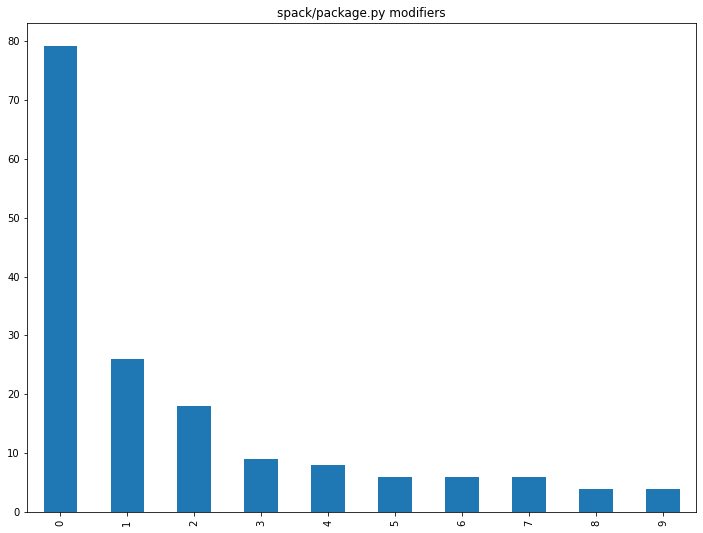

In [ ]:
makef_users = user_file_df['a/lib/spack/spack/package.py b/lib/spack/spack/package.py'].sort_values(ascending=False)
makef_users.head(10).plot.bar(figsize=(12,9), title='spack/package.py modifiers', use_index=False)

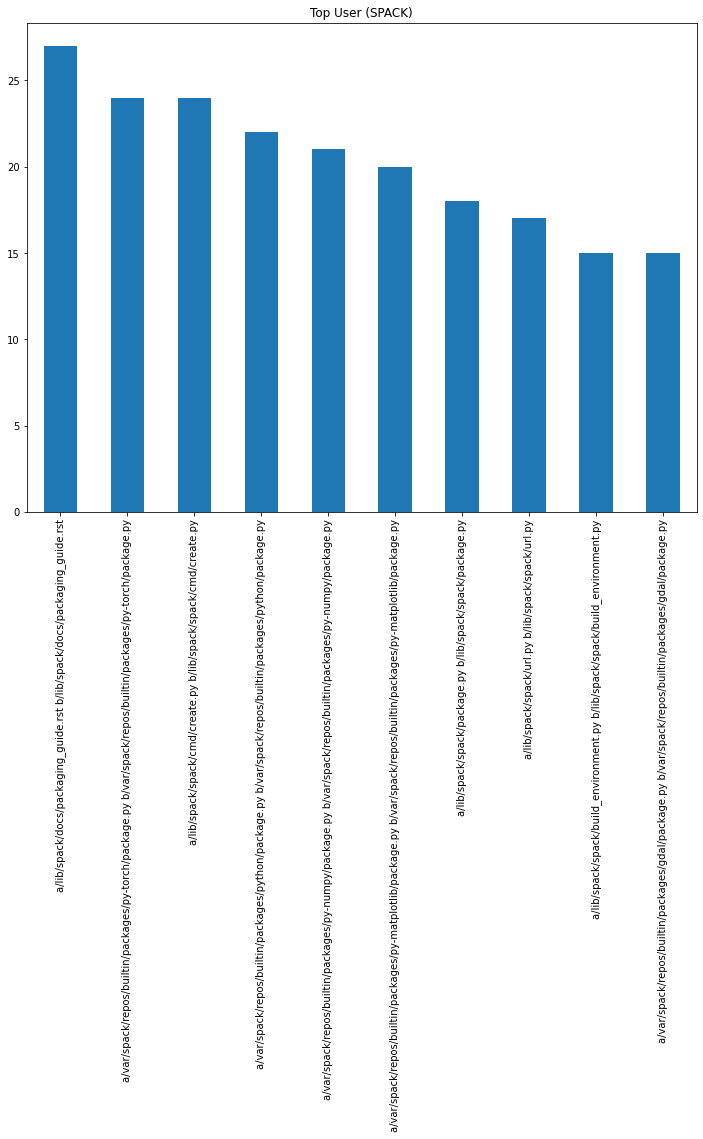

In [ ]:
make_topu_files = user_file_df.transpose()["b'Adam J. Stewart <ajstewart426@gmail.com>'"].sort_values(ascending=False)

make_topu_files.head(10).plot.bar(figsize=(12,9), title='Top User (SPACK)', use_index=True)

In [ ]:
user_stats = mat_df_all.describe().transpose()

In [ ]:
import numpy as np

In [ ]:
mat_df_all_15 = make_pandas_df(dims=(15,15))

In [ ]:
mat_15 = mat_df_all_15.values
mat_15

array([[18, 79,  0,  1,  9,  0,  0, 26,  1,  0,  3,  0,  6,  1,  4],
       [ 0, 59,  0,  2,  7,  1,  0,  3,  0,  0, 17,  0, 10,  2, 26],
       [15, 41,  6,  1,  6,  0,  0, 13,  0,  1,  8,  0,  5,  2, 13],
       [ 1,  0, 56,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 9, 65,  1,  1,  0,  0,  0,  8,  0,  0,  3,  0,  1,  1,  7],
       [ 0, 23,  0,  0,  2,  0,  0,  4,  0,  0, 43,  0,  0,  1, 23],
       [27, 20,  8,  1,  4,  2,  0,  2,  1,  1,  1,  0,  6,  0,  0],
       [ 0,  0, 79,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4, 26,  1,  1,  3, 19,  0,  3,  0,  0,  0,  0,  2,  1, 12],
       [11,  1,  1,  1,  0,  6,  0,  0,  5,  0,  0,  0,  0,  2,  0],
       [ 8, 35,  0,  0, 26,  0,  0,  8,  1,  0,  0,  0,  6,  0,  0],
       [ 2,  2, 24,  0,  0,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [22,  2,  2,  0,  3,  0,  0,  1,  1,  0,  0,  0,  1,  1,  0],
       [ 7,  0,  3,  1,  2, 11,  0,  1,  2,  1,  0,  0,  1,  0,  0],
       [ 6, 59,  0,  0,  2,  0,  0

In [ ]:
arr = np.asarray([1 / (a + 1) for a in list(f_index_all.values())][:15])

In [ ]:
rankings = np.dot(mat_15.T, arr)

In [ ]:
z = sorted(zip(list(ppl_index_all.keys())[:15], rankings), key=lambda x : x[1])
names, rs = map(list,zip(*z))

<BarContainer object of 15 artists>

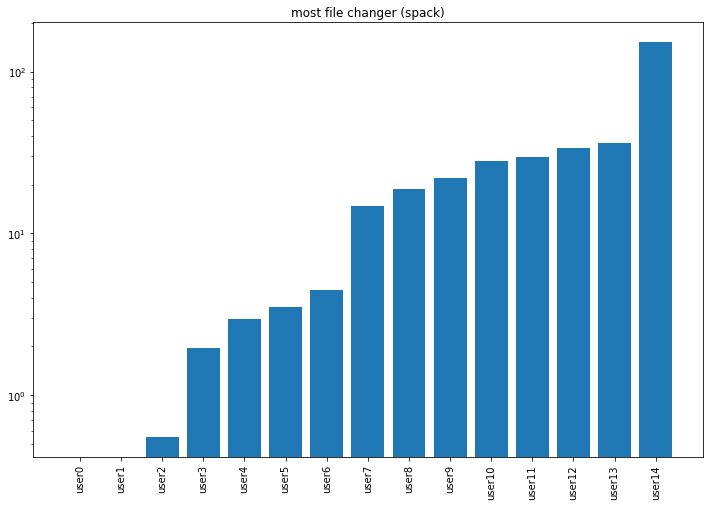

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,8))
plt.xticks(rotation='vertical')
plt.title('most file changer (spack)')
plt.yscale('log')
plt.bar(['user' + str(names.index(i)) for i in names], rs)

In [ ]:
import seaborn as sb 

def plot(df):
  fig, ax = plt.subplots(figsize=(12,8))
  sb.heatmap(df, annot=True, linewidths=.5, xticklabels=False)
  plt.title('users vs files (spack)')
  plt.savefig("spackheat.png")
  plt.show()

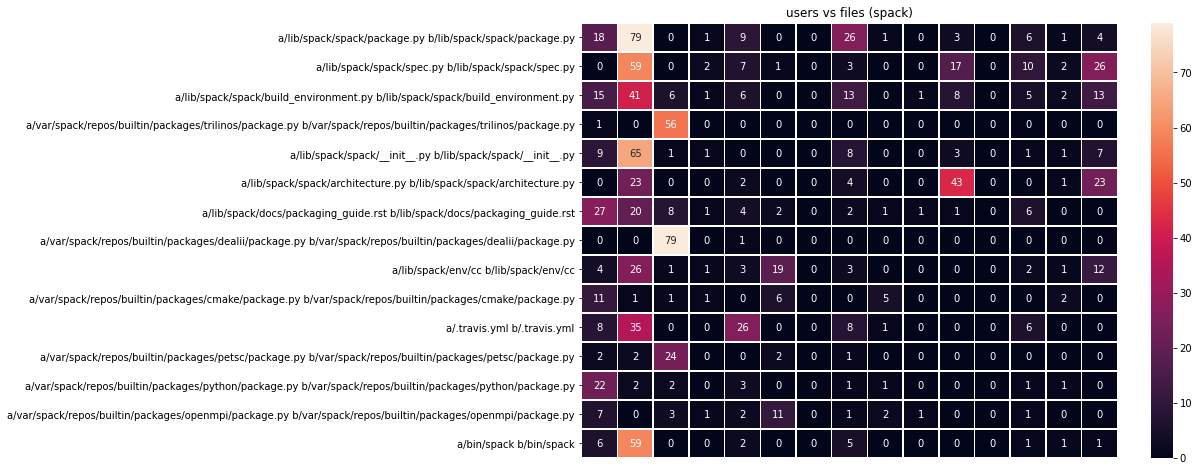

In [ ]:
plot(mat_df_all_15)

In [ ]:
!ls

drive  familiarity.pdf	sample_data  spackheat.pdf


In [ ]:
list(mat_df_all_15.iloc[:, 0])

[18, 0, 15, 1, 9, 0, 27, 0, 4, 11, 8, 2, 22, 7, 6]

In [ ]:
def get_familiarity_index(vec):
  n      = len(vec)
  mean_v = sum(vec) / n
  gini_ans = 0
  for i in range(n):
    for j in range(n):
      x_i = vec[i] 
      x_j = vec[j]
      gini = abs(x_i - x_j) / (2*(n**2)*mean_v) 
      gini_ans += gini 
  return gini_ans 

In [ ]:
from math import sqrt, isnan

In [ ]:
def domain_familiarity(vec):
  ans = 0 
  for i in range(len(vec)):
    ans += vec[i]**2 
  return sqrt(ans)

In [ ]:
fam_indices = [] 
dom_indices = []
for i in range(len(list(mat_df_all_15.columns))): 
  vec = mat_df_all_15.iloc[:, i] 
  fam_index = get_familiarity_index(vec) 
  dom_index = domain_familiarity(vec)  
  fam_indices.append(1- fam_index) 
  dom_indices.append(dom_index)
dom_indices = [u / domain_familiarity(dom_indices) for u in dom_indices]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [ ]:
for i in range(len(fam_indices)): 
  if isnan(fam_indices[i]): 
    fam_indices[i] = 0  
fam_indices

[0.4810256410256408,
 0.46310679611650496,
 0.21620626151012923,
 0.4814814814814812,
 0.3702564102564092,
 0.20325203252032564,
 0,
 0.38311111111111085,
 0.26060606060605973,
 0.20000000000000084,
 0.17155555555555602,
 0,
 0.3948717948717959,
 0.5000000000000011,
 0.28217054263565877]

In [ ]:
dom_indices

[0.22893348608635036,
 0.7341919015902012,
 0.4972849140859185,
 0.01643646641164957,
 0.14776207951914452,
 0.1137672922358207,
 0.0,
 0.15974228329555037,
 0.028468794921876362,
 0.00858366463540355,
 0.233553507167562,
 0.0,
 0.07693441136472828,
 0.021025598479911704,
 0.1972375969397948]

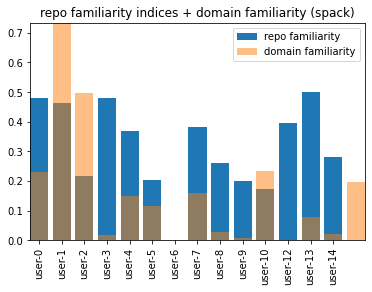

In [ ]:
ax = plt.subplot(111)
plt.xticks(rotation='vertical')
ax.bar(['user-' + str(fam_indices.index(i)) for i in fam_indices], fam_indices)
plt.title('repo familiarity indices + domain familiarity (spack)')
ax.bar(range(len(dom_indices)), dom_indices, alpha=0.5) 
ax.autoscale(tight=True)
plt.legend(['repo familiarity', 'domain familiarity'])
plt.savefig("familiarity.png")

In [ ]:
!ls

drive  familiarity.pdf	sample_data  spackheat.pdf


In [ ]:
from google.colab import files
files.download("familiarity.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("spackheat.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sorted_people_commits()[0]

,year,month,day,doy,dow,full_date,files,files_dict,message,person,locc,locc+,locc-,sha
1266,2016,1,11,11,Monday,2016-01-11 13:54:26-06:00,['a/var/spack/packages/patchelf/package.py b/v...,{'a/var/spack/packages/patchelf/package.py b/v...,Add PatchELF package\n,b'Adam J. Stewart <ajstewart426@gmail.com>',16,16,0,b'adbe1d4f06028ba13e21386f7d62939d4b2eb740'
1267,2016,1,11,11,Monday,2016-01-11 13:43:31-06:00,['a/var/spack/packages/szip/package.py b/var/s...,{'a/var/spack/packages/szip/package.py b/var/s...,Add SZip package\n,b'Adam J. Stewart <ajstewart426@gmail.com>',21,21,0,b'6a51b1d5705096264a1280a35185fd7293aafde3'
1275,2016,1,12,12,Tuesday,2016-01-12 13:28:48-06:00,['a/var/spack/packages/mpfr/package.py b/var/s...,{'a/var/spack/packages/mpfr/package.py b/var/s...,Add required dependency version\n,b'Adam J. Stewart <ajstewart426@gmail.com>',2,1,1,b'a6f2cc9cbf82bae1b82680651ac6c1804524c77c'
1276,2016,1,12,12,Tuesday,2016-01-12 13:21:53-06:00,['a/var/spack/packages/mpc/package.py b/var/sp...,{'a/var/spack/packages/mpc/package.py b/var/sp...,Add different URL for older source code\n,b'Adam J. Stewart <ajstewart426@gmail.com>',10,8,2,b'180c673c782d10864dce6cd7df43465dd05579a1'
1277,2016,1,12,12,Tuesday,2016-01-12 13:00:05-06:00,['a/var/spack/packages/hwloc/package.py b/var/...,{'a/var/spack/packages/hwloc/package.py b/var/...,Add url_for_version function to calculate ...,b'Adam J. Stewart <ajstewart426@gmail.com>',2,2,0,b'6985d2c914159f7978c304530f7fb1eb38b2b78d'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15701,2020,9,9,253,Wednesday,2020-09-09 03:25:57-05:00,['a/var/spack/repos/builtin/packages/nn-c/pack...,{'a/var/spack/repos/builtin/packages/nn-c/pack...,nn-c: fix pic flags (#18478)\n,b'Adam J. Stewart <ajstewart426@gmail.com>',6,3,3,b'8494d26c0a1fc8bc4644ac01e4ad071eefc3ae2b'
15702,2020,9,9,253,Wednesday,2020-09-09 03:16:50-05:00,['a/var/spack/repos/builtin/packages/py-torchv...,{'a/var/spack/repos/builtin/packages/py-torchv...,py-torchvision: add variant to set image b...,b'Adam J. Stewart <ajstewart426@gmail.com>',2,0,2,b'ba47a057f0200fb13001a5702258874b53e6e728'
15703,2020,9,9,253,Wednesday,2020-09-09 03:12:46-05:00,['a/var/spack/repos/builtin/packages/readline/...,{'a/var/spack/repos/builtin/packages/readline/...,readline: fix build with ncurses~termlib (...,b'Adam J. Stewart <ajstewart426@gmail.com>',2,1,1,b'96364235e3358c2c49ed416e432ac125683280bb'
15704,2020,9,9,253,Wednesday,2020-09-09 03:11:29-05:00,['a/var/spack/repos/builtin/packages/pcre2/pac...,{'a/var/spack/repos/builtin/packages/pcre2/pac...,pcre2: fix libs property (#18525)\n,b'Adam J. Stewart <ajstewart426@gmail.com>',10,6,4,b'4307b732994e4e48853d5a51e77cbd3c133808ee'


In [ ]:
import datetime 
from dateutil import parser

In [ ]:
srtd_ppl = sorted_people_commits()

In [ ]:
freq_avg_commit_count = []
p_index = []
for i in range(len(srtd_ppl)):
  person    = list(srtd_ppl[i]['person'])[0]
  avg_i     = srtd_ppl[i]['locc'].mean() 
  t_changes = srtd_ppl[i]['locc'].sum() 
  count_i = srtd_ppl[i]['locc'].count() 
  st_date   = parser.parse(list(srtd_ppl[i]['full_date'])[0])
  dates_l = list(srtd_ppl[i]['full_date'])
  shas    = list(srtd_ppl[i]['sha'])
  total = datetime.timedelta() # initialize date count 
  count = float(len(dates_l) - 1) if len(dates_l) != 1 else 1.0 # avoid divide by zero error
  for i in range(1, len(dates_l)):
    x = parser.parse(dates_l[i-1])
    y = parser.parse(dates_l[i])
    t = y - x 
    total += t 
  t_days = total.days if total.days > 0 else 1.0
  time_freqs_person = total.days / count  
  p_index.append(person)
  my_dict = {'avg_changes (per commit)' : avg_i
              , 'changes / day' : t_changes / t_days 
              , 'average timegap (days)' : time_freqs_person 
              , 'freq / avg_changes' : time_freqs_person / avg_i
              , 'total commits' : count_i
              , 'all_shas' : shas 
              }
  freq_avg_commit_count.append(my_dict)

In [ ]:
f_avg_pd = pd.DataFrame(freq_avg_commit_count, index=p_index)
f_avg_pd.head(20)

,avg_changes (per commit),changes / day,average timegap (days),freq / avg_changes,total commits,all_shas
b'Adam J. Stewart <ajstewart426@gmail.com>',16.745524,15.561497,1.076775,0.064302,1564,"[b'adbe1d4f06028ba13e21386f7d62939d4b2eb740', ..."
b'Todd Gamblin <tgamblin@llnl.gov>',31.370656,17.811472,1.762395,0.056180,1554,"[b'cc76c0f5f9f8021cfb7423a226bd431c00d791ce', ..."
b'Denis Davydov <davydden@gmail.com>',30.063584,12.039352,2.501931,0.083221,519,"[b'db61a09cf14cc791d7692aac0329e8958b228fb6', ..."
b'George Hartzell <hartzell@alerce.com>',24.344512,5.302125,4.605505,0.189180,328,"[b'1b9e8a0e65e927c74ea44a881c932a33cfb1745b', ..."
b'Massimiliano Culpo <massimiliano.culpo@gmail.com>',18.162420,5.737425,3.175719,0.174851,314,"[b'aa248586481fa089caccdf18c338d797fabe6f0f', ..."
b'Erik Schnetter <schnetter@gmail.com>',13.254967,2.301898,5.777409,0.435867,302,"[b'cc49f9b6576234fbfa2de05df15f1dbb43b4926f', ..."
b'alalazo <massimiliano.culpo@googlemail.com>',14.840000,7.077901,2.103679,0.141757,300,"[b'c5b9732aed27e2061d2b50c02bc9933b5686c946', ..."
b'darmac <xiaojun2@hisilicon.com>',30.967871,30.478261,1.020161,0.032943,249,"[b'03203a86b4337559c9db10bfcbcb186709430e99', ..."
b'Axel Huebl <axel.huebl@plasma.ninja>',14.604167,2.447626,5.991632,0.410269,240,"[b'b33777fd2f7eb377727cead7f38ccdf63cd3a71d', ..."
b'Glenn Johnson <glenn-johnson@uiowa.edu>',46.388889,6.742236,6.909871,0.148955,234,"[b'6bbadbfaac406f9abe81e64f174d8a2b4c9c255e', ..."


In [ ]:
f_avg_pd.head(20).sort_values('freq / avg_changes', ascending=False)

,avg_changes (per commit),changes / day,average timegap (days),freq / avg_changes,total commits,all_shas
b'Mario Melara <maamelara@gmail.com>',9.106796,1.314646,6.960976,0.764372,206,"[b'b6d2a12ceb090692aa2be363b46d7f25486c0245', ..."
b'Gregory Becker <becker33@llnl.gov>',16.647668,1.787980,9.359375,0.562203,193,"[b'fb1874165b420c5a8866bec7ac87a98e97f2b670', ..."
b'Erik Schnetter <schnetter@gmail.com>',13.254967,2.301898,5.777409,0.435867,302,"[b'cc49f9b6576234fbfa2de05df15f1dbb43b4926f', ..."
b'Axel Huebl <axel.huebl@plasma.ninja>',14.604167,2.447626,5.991632,0.410269,240,"[b'b33777fd2f7eb377727cead7f38ccdf63cd3a71d', ..."
b'Michael Kuhn <suraia@ikkoku.de>',12.550505,2.588542,4.873096,0.388279,198,"[b'b7d9b58cc5de8a36d43cc082cac0e1ccb6e05f74', ..."
b'Christoph Junghans <christoph.junghans@gmail.com>',16.953488,3.509025,4.859649,0.286646,172,"[b'8dc056130cb25990408464d55f1011175e27087e', ..."
b'Sinan <sbulutw@gmail.com>',24.022989,4.404636,5.485549,0.228346,174,"[b'7f319b9f84e441cbe893fd2cc68ecd77cfcfd987', ..."
b'George Hartzell <hartzell@alerce.com>',24.344512,5.302125,4.605505,0.189180,328,"[b'1b9e8a0e65e927c74ea44a881c932a33cfb1745b', ..."
b'Massimiliano Culpo <massimiliano.culpo@googlemail.com>',22.340000,5.698980,3.939698,0.176352,200,"[b'17de9a37f1d064e18ff61145196b1cb77ae8b64b', ..."
b'Massimiliano Culpo <massimiliano.culpo@gmail.com>',18.162420,5.737425,3.175719,0.174851,314,"[b'aa248586481fa089caccdf18c338d797fabe6f0f', ..."


In [ ]:
def normalize_col(names, dframe, norm='min_max'):
  for name in names:
    if norm == 'min_max':
      dframe[name] = (dframe[name] - dframe[name].min()) / (dframe[name].max() - dframe[name].min())
    if norm == 'mean':
      dframe[name] = (dframe[name] - dframe[name].mean()) / dframe[name].std()
  return dframe

In [ ]:
normalize_col(['average timegap (days)',  'total commits', 'avg_changes (per commit)'], f_avg_pd)

,avg_changes (per commit),changes / day,average timegap (days),freq / avg_changes,total commits,all_shas
b'Adam J. Stewart <ajstewart426@gmail.com>',0.002016,15.561497,0.002432,0.064302,1.000000,"[b'adbe1d4f06028ba13e21386f7d62939d4b2eb740', ..."
b'Todd Gamblin <tgamblin@llnl.gov>',0.003888,17.811472,0.003235,0.056180,0.993602,"[b'cc76c0f5f9f8021cfb7423a226bd431c00d791ce', ..."
b'Denis Davydov <davydden@gmail.com>',0.003720,12.039352,0.004101,0.083221,0.331414,"[b'db61a09cf14cc791d7692aac0329e8958b228fb6', ..."
b'George Hartzell <hartzell@alerce.com>',0.002988,5.302125,0.006564,0.189180,0.209213,"[b'1b9e8a0e65e927c74ea44a881c932a33cfb1745b', ..."
b'Massimiliano Culpo <massimiliano.culpo@gmail.com>',0.002197,5.737425,0.004890,0.174851,0.200256,"[b'aa248586481fa089caccdf18c338d797fabe6f0f', ..."
...,...,...,...,...,...,...
b'Auriane R <48684432+aurianer@users.noreply.github.com>',0.000000,1.000000,0.001171,0.000000,0.000000,[b'93221f8bf9409fc8a038832301abba817529a6bb']
b'Luke Dalessandro <ldalessa@uw.edu>',0.000256,3.000000,0.001171,0.000000,0.000000,[b'76f3d84a1b29e85e9a089046a057ef8fc92f5f35']
b'ketsubouchi <kenta.tsubouchi@hac-inc.co.jp>',0.000128,2.000000,0.001171,0.000000,0.000000,[b'8a02ef4d51a08ed8bcdd97e971e514a5af75c5cb']
b'Richarda Butler <39577672+RikkiButler20@users.noreply.github.com>',0.000128,2.000000,0.001171,0.000000,0.000000,[b'd599e4d9d440ee146fb864b3ba043c82f31e5f8b']


In [ ]:
f_avg_pd.head(20).sort_values('average timegap (days)', ascending=False)

,avg_changes (per commit),changes / day,average timegap (days),freq / avg_changes,total commits,all_shas
b'Gregory Becker <becker33@llnl.gov>',0.002003,1.787980,0.012130,0.562203,0.122841,"[b'fb1874165b420c5a8866bec7ac87a98e97f2b670', ..."
b'Mario Melara <maamelara@gmail.com>',0.001038,1.314646,0.009322,0.764372,0.131158,"[b'b6d2a12ceb090692aa2be363b46d7f25486c0245', ..."
b'Glenn Johnson <glenn-johnson@uiowa.edu>',0.005810,6.742236,0.009262,0.148955,0.149072,"[b'6bbadbfaac406f9abe81e64f174d8a2b4c9c255e', ..."
b'Axel Huebl <axel.huebl@plasma.ninja>',0.001741,2.447626,0.008187,0.410269,0.152911,"[b'b33777fd2f7eb377727cead7f38ccdf63cd3a71d', ..."
b'Erik Schnetter <schnetter@gmail.com>',0.001569,2.301898,0.007936,0.435867,0.192578,"[b'cc49f9b6576234fbfa2de05df15f1dbb43b4926f', ..."
b'Sinan <sbulutw@gmail.com>',0.002947,4.404636,0.007594,0.228346,0.110685,"[b'7f319b9f84e441cbe893fd2cc68ecd77cfcfd987', ..."
b'Michael Kuhn <suraia@ikkoku.de>',0.001479,2.588542,0.006877,0.388279,0.126040,"[b'b7d9b58cc5de8a36d43cc082cac0e1ccb6e05f74', ..."
b'Christoph Junghans <christoph.junghans@gmail.com>',0.002042,3.509025,0.006861,0.286646,0.109405,"[b'8dc056130cb25990408464d55f1011175e27087e', ..."
b'George Hartzell <hartzell@alerce.com>',0.002988,5.302125,0.006564,0.189180,0.209213,"[b'1b9e8a0e65e927c74ea44a881c932a33cfb1745b', ..."
b'Massimiliano Culpo <massimiliano.culpo@googlemail.com>',0.002732,5.698980,0.005784,0.176352,0.127319,"[b'17de9a37f1d064e18ff61145196b1cb77ae8b64b', ..."


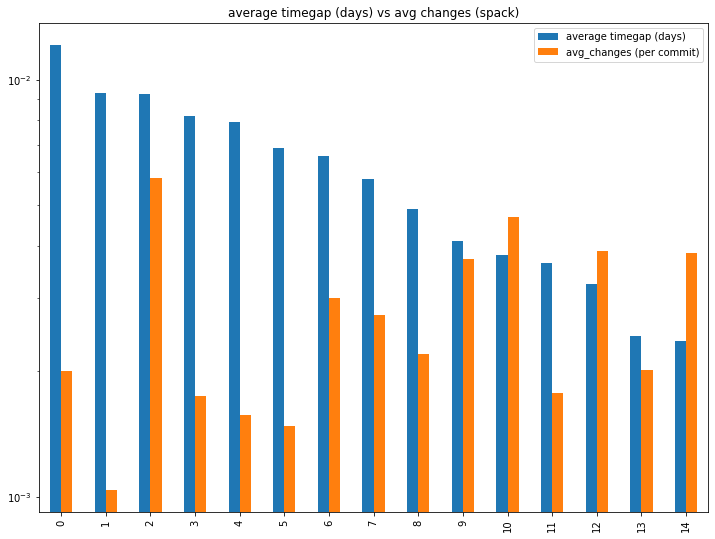

In [ ]:
f_avg_pd.head(15).sort_values('average timegap (days)', ascending=False)[['average timegap (days)', 'avg_changes (per commit)']].plot.bar(figsize=(12,9), title='average timegap (days) vs avg changes (spack)', logy=True, use_index=False)


In [ ]:
n_user_file_df = pd.concat([f_avg_pd, user_file_df], axis=1)
n_user_file_df

,avg_changes (per commit),changes / day,average timegap (days),freq / avg_changes,total commits,all_shas,a/lib/spack/spack/package.py b/lib/spack/spack/package.py,a/lib/spack/spack/spec.py b/lib/spack/spack/spec.py,a/lib/spack/spack/build_environment.py b/lib/spack/spack/build_environment.py,a/lib/spack/spack/__init__.py b/lib/spack/spack/__init__.py,...,a/var/spack/repos/builtin/packages/espanso/package.py b/var/spack/repos/builtin/packages/espanso/package.py,a/var/spack/repos/builtin/packages/xdotool/package.py b/var/spack/repos/builtin/packages/xdotool/package.py,a/var/spack/repos/builtin/packages/sprng/package.py b/var/spack/repos/builtin/packages/sprng/package.py,a/var/spack/repos/builtin/packages/hipcub/package.py b/var/spack/repos/builtin/packages/hipcub/package.py,a/var/spack/repos/builtin/packages/miopengemm/package.py b/var/spack/repos/builtin/packages/miopengemm/package.py,a/var/spack/repos/builtin/packages/rccl/package.py b/var/spack/repos/builtin/packages/rccl/package.py,a/var/spack/repos/builtin/packages/rocm-clang-ocl/package.py b/var/spack/repos/builtin/packages/rocm-clang-ocl/package.py,a/var/spack/repos/builtin/packages/rocsparse/package.py b/var/spack/repos/builtin/packages/rocsparse/package.py,a/var/spack/repos/builtin/packages/rocthrust/package.py b/var/spack/repos/builtin/packages/rocthrust/package.py,a/var/spack/repos/builtin/packages/vifi/package.py b/var/spack/repos/builtin/packages/vifi/package.py
b'Adam J. Stewart <ajstewart426@gmail.com>',0.002016,15.561497,0.002432,0.064302,1.000000,"[b'adbe1d4f06028ba13e21386f7d62939d4b2eb740', ...",18,0,15,9,...,0,0,0,0,0,0,0,0,0,0
b'Todd Gamblin <tgamblin@llnl.gov>',0.003888,17.811472,0.003235,0.056180,0.993602,"[b'cc76c0f5f9f8021cfb7423a226bd431c00d791ce', ...",79,59,41,65,...,0,0,0,0,0,0,0,0,0,0
b'Denis Davydov <davydden@gmail.com>',0.003720,12.039352,0.004101,0.083221,0.331414,"[b'db61a09cf14cc791d7692aac0329e8958b228fb6', ...",0,0,6,1,...,0,0,0,0,0,0,0,0,0,0
b'George Hartzell <hartzell@alerce.com>',0.002988,5.302125,0.006564,0.189180,0.209213,"[b'1b9e8a0e65e927c74ea44a881c932a33cfb1745b', ...",1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
b'Massimiliano Culpo <massimiliano.culpo@gmail.com>',0.002197,5.737425,0.004890,0.174851,0.200256,"[b'aa248586481fa089caccdf18c338d797fabe6f0f', ...",9,6,6,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'Auriane R <48684432+aurianer@users.noreply.github.com>',0.000000,1.000000,0.001171,0.000000,0.000000,[b'93221f8bf9409fc8a038832301abba817529a6bb'],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b'Luke Dalessandro <ldalessa@uw.edu>',0.000256,3.000000,0.001171,0.000000,0.000000,[b'76f3d84a1b29e85e9a089046a057ef8fc92f5f35'],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b'ketsubouchi <kenta.tsubouchi@hac-inc.co.jp>',0.000128,2.000000,0.001171,0.000000,0.000000,[b'8a02ef4d51a08ed8bcdd97e971e514a5af75c5cb'],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b'Richarda Butler <39577672+RikkiButler20@users.noreply.github.com>',0.000128,2.000000,0.001171,0.000000,0.000000,[b'd599e4d9d440ee146fb864b3ba043c82f31e5f8b'],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_file_df.to_csv("spack_user_file_mat.csv")

In [ ]:
topu_pd = sorted_people_commits()[0]
topu_pd

,year,month,day,doy,dow,full_date,files,message,person,locc,sha
1268,2016,1,11,11,Monday,2016-01-11 13:54:26-06:00,['a/var/spack/packages/patchelf/package.py b/v...,Add PatchELF package\n,b'Adam J. Stewart <ajstewart426@gmail.com>',16,b'adbe1d4f06028ba13e21386f7d62939d4b2eb740'
1269,2016,1,11,11,Monday,2016-01-11 13:43:31-06:00,['a/var/spack/packages/szip/package.py b/var/s...,Add SZip package\n,b'Adam J. Stewart <ajstewart426@gmail.com>',21,b'6a51b1d5705096264a1280a35185fd7293aafde3'
1275,2016,1,12,12,Tuesday,2016-01-12 13:28:48-06:00,['a/var/spack/packages/mpfr/package.py b/var/s...,Add required dependency version\n,b'Adam J. Stewart <ajstewart426@gmail.com>',2,b'a6f2cc9cbf82bae1b82680651ac6c1804524c77c'
1276,2016,1,12,12,Tuesday,2016-01-12 13:21:53-06:00,['a/var/spack/packages/mpc/package.py b/var/sp...,Add different URL for older source code\n,b'Adam J. Stewart <ajstewart426@gmail.com>',10,b'180c673c782d10864dce6cd7df43465dd05579a1'
1277,2016,1,12,12,Tuesday,2016-01-12 13:00:05-06:00,['a/var/spack/packages/hwloc/package.py b/var/...,Add url_for_version function to calculate ...,b'Adam J. Stewart <ajstewart426@gmail.com>',2,b'6985d2c914159f7978c304530f7fb1eb38b2b78d'
...,...,...,...,...,...,...,...,...,...,...,...
15356,2020,8,17,230,Monday,2020-08-17 11:24:19-05:00,['a/var/spack/repos/builtin/packages/ffmpeg/pa...,py-torchvision: fix linking to -lavcodec (...,b'Adam J. Stewart <ajstewart426@gmail.com>',27,b'9350ecf0469146f0b477a6e7dcf75ceefb4e2bc1'
15357,2020,8,17,230,Monday,2020-08-17 03:54:30-05:00,['a/var/spack/repos/builtin/packages/hdf/packa...,hdf+external-xdr does not build on macOS (...,b'Adam J. Stewart <ajstewart426@gmail.com>',2,b'8a8d36d828dcbba1b3c5607eebada16953b626ee'
15378,2020,8,18,231,Tuesday,2020-08-18 13:17:08-05:00,['a/var/spack/repos/builtin/packages/jdk/packa...,Java: add spack external find support (#18...,b'Adam J. Stewart <ajstewart426@gmail.com>',4,b'00e9e1b3c7bda5db7b47416932728a5832ff3e06'
15379,2020,8,18,231,Tuesday,2020-08-18 05:10:18-05:00,['a/var/spack/repos/builtin/packages/py-accima...,py-accimage: add new package (#18122)\n,b'Adam J. Stewart <ajstewart426@gmail.com>',27,b'17d96b615a5d4b99f532b2110c65ad188be7f005'


In [ ]:
topu_pd.index = pd.to_datetime(topu_pd['full_date'])

In [ ]:
topu_pd

,year,month,day,doy,dow,full_date,files,message,person,locc,sha
full_date,,,,,,,,,,,
2016-01-11 13:54:26-06:00,2016,1,11,11,Monday,2016-01-11 13:54:26-06:00,['a/var/spack/packages/patchelf/package.py b/v...,Add PatchELF package\n,b'Adam J. Stewart <ajstewart426@gmail.com>',16,b'adbe1d4f06028ba13e21386f7d62939d4b2eb740'
2016-01-11 13:43:31-06:00,2016,1,11,11,Monday,2016-01-11 13:43:31-06:00,['a/var/spack/packages/szip/package.py b/var/s...,Add SZip package\n,b'Adam J. Stewart <ajstewart426@gmail.com>',21,b'6a51b1d5705096264a1280a35185fd7293aafde3'
2016-01-12 13:28:48-06:00,2016,1,12,12,Tuesday,2016-01-12 13:28:48-06:00,['a/var/spack/packages/mpfr/package.py b/var/s...,Add required dependency version\n,b'Adam J. Stewart <ajstewart426@gmail.com>',2,b'a6f2cc9cbf82bae1b82680651ac6c1804524c77c'
2016-01-12 13:21:53-06:00,2016,1,12,12,Tuesday,2016-01-12 13:21:53-06:00,['a/var/spack/packages/mpc/package.py b/var/sp...,Add different URL for older source code\n,b'Adam J. Stewart <ajstewart426@gmail.com>',10,b'180c673c782d10864dce6cd7df43465dd05579a1'
2016-01-12 13:00:05-06:00,2016,1,12,12,Tuesday,2016-01-12 13:00:05-06:00,['a/var/spack/packages/hwloc/package.py b/var/...,Add url_for_version function to calculate ...,b'Adam J. Stewart <ajstewart426@gmail.com>',2,b'6985d2c914159f7978c304530f7fb1eb38b2b78d'
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17 11:24:19-05:00,2020,8,17,230,Monday,2020-08-17 11:24:19-05:00,['a/var/spack/repos/builtin/packages/ffmpeg/pa...,py-torchvision: fix linking to -lavcodec (...,b'Adam J. Stewart <ajstewart426@gmail.com>',27,b'9350ecf0469146f0b477a6e7dcf75ceefb4e2bc1'
2020-08-17 03:54:30-05:00,2020,8,17,230,Monday,2020-08-17 03:54:30-05:00,['a/var/spack/repos/builtin/packages/hdf/packa...,hdf+external-xdr does not build on macOS (...,b'Adam J. Stewart <ajstewart426@gmail.com>',2,b'8a8d36d828dcbba1b3c5607eebada16953b626ee'
2020-08-18 13:17:08-05:00,2020,8,18,231,Tuesday,2020-08-18 13:17:08-05:00,['a/var/spack/repos/builtin/packages/jdk/packa...,Java: add spack external find support (#18...,b'Adam J. Stewart <ajstewart426@gmail.com>',4,b'00e9e1b3c7bda5db7b47416932728a5832ff3e06'


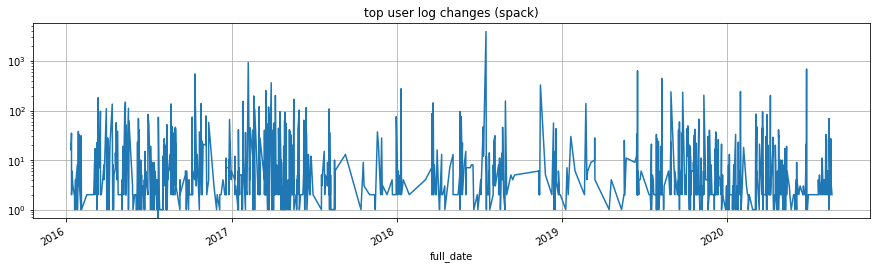

In [ ]:
topu_pd['locc'].plot(figsize=(15,4), grid=True, logy=True, title='top user log changes (spack)')

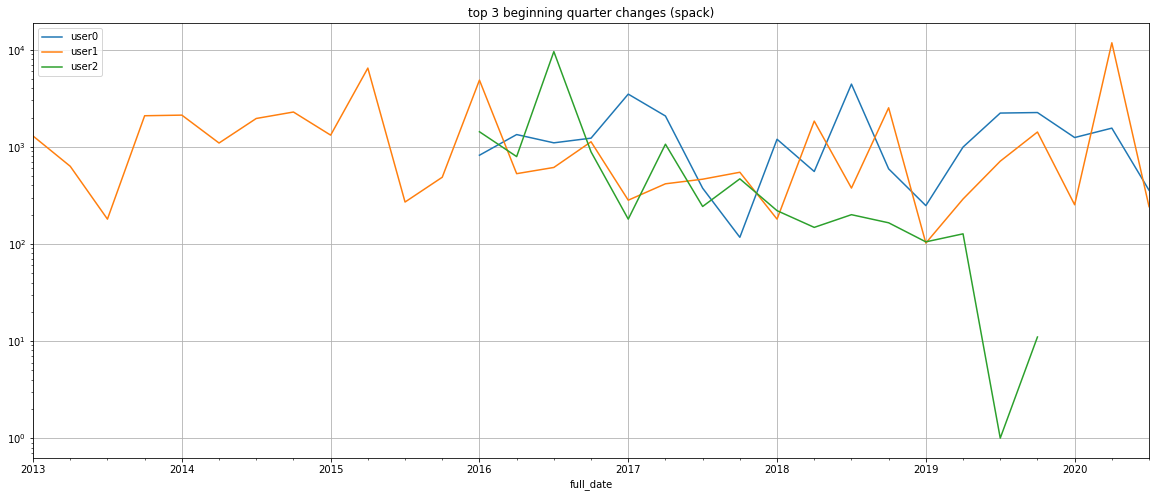

In [ ]:
fig, ax = plt.subplots() 
persons = [] 
for i in range(3):
  topi_pd = sorted_people_commits()[i]
  p       = list(topi_pd['person'])[0]
#   persons.append(p)
  persons.append('user' + str(i))
  topi_pd.index = pd.to_datetime(topi_pd['full_date'])
  topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
  quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='BQ')).sum() 
  quarter_checkin_i['locc'].plot(figsize=(20,8), grid=True, ax=ax, logy=True)
ax.set_title('top 3 beginning quarter changes (spack)')
ax.legend(persons)